In [12]:
import torch

import vcl
import dataset
import coresets
import plots
import numpy as np
from models import MultiheadModel, MultiheadModelConvolutional

import sys, os

import numpy as np
import torch
import torchvision
from torchvision import transforms
import random

In [13]:
def run_vanilla_vcl(model, dataloaders, num_tasks, num_epochs, device, beta=0.01):
    model.reset_parameters()
    coreset_size = 0
    single_head = False
    coreset_method = coresets.attach_random_coreset_split
    all_accs = vcl.run_vcl(num_tasks, single_head, num_epochs, dataloaders,
                model, coreset_method, coreset_size, beta=beta)
    return all_accs

COPY BACK TO ORIGINAL AFTER DONE

In [14]:
def _extract_class_specific_idx(dataset, target_classes):
    """
    dataset: torchvision.datasets.MNIST
    target_classes: list
    """
    dataset.targets = torch.tensor(dataset.targets)
    idx = torch.zeros_like(dataset.targets, dtype=torch.bool)
    for target in target_classes:
        idx = idx | (dataset.targets==target)
    
    return idx
def SplitCifar10DataloaderTEST(class_distribution, batch_size=256, grayscale=True, data_subset=1):
    """
    class_distribution: list[list]
    """
    rsz = 32
    if grayscale:
        transform = transforms.Compose([
            transforms.Resize((rsz, rsz)),
            transforms.ToTensor(),
            transforms.Grayscale()
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((rsz, rsz)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    root = "./data/cifar10"
    dataset = torchvision.datasets.CIFAR10
    trainset = dataset(root=root, train=True, download=True, transform=transform)
    testset = dataset(root=root, train=False, download=True, transform=transform)

    dataloaders = []

    for classes in class_distribution:
        train_idx = _extract_class_specific_idx(trainset, classes)
        train_idx = torch.where(train_idx)[0]

        # Select a subset of indices
        subset_size_train = int(len(train_idx) * data_subset)
        train_idx_subset = torch.randperm(len(train_idx))[:subset_size_train]
        
        sub_train_sampler = torch.utils.data.SubsetRandomSampler(train_idx[train_idx_subset])
        sub_train_loader = torch.utils.data.DataLoader(
            trainset, batch_size=batch_size, sampler=sub_train_sampler)
        
                # Test subset
        test_idx = _extract_class_specific_idx(testset, classes)
        test_idx = torch.where(test_idx)[0]
        # Select a subset of indices
        subset_size_test = int(len(test_idx) * data_subset)
        test_idx_subset = torch.randperm(len(test_idx))[:subset_size_test]
        
        sub_test_sampler = torch.utils.data.SubsetRandomSampler(test_idx[test_idx_subset])
        sub_test_loader = torch.utils.data.DataLoader(
            testset, batch_size=batch_size, sampler=sub_test_sampler)

        # train_idx = _extract_class_specific_idx(trainset, classes)
        # train_idx = torch.where(train_idx)[0]
        # sub_train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        # sub_train_loader = torch.utils.data.DataLoader(
        #     trainset, batch_size=batch_size, sampler=sub_train_sampler)

        # test_idx = _extract_class_specific_idx(testset, classes)
        # test_idx = torch.where(test_idx)[0]
        # sub_test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
        # sub_test_loader = torch.utils.data.DataLoader(
        #     testset, batch_size=batch_size, sampler=sub_test_sampler)
        
        dataloaders.append((sub_train_loader, sub_test_loader))

    return dataloaders

In [15]:
import torch.nn as nn
import torch.nn.functional as F

from layers import BaysLinear
from layers import BaysConv


# following guidance of https://openreview.net/pdf?id=_IM-AfFhna9 (page 28)
class EDITED_CONV_CURRENT(nn.Module):
    """
    Defines a Multi head with Bayesian layers, used for tasks with separate classifiers.
    """
    
    def __init__(self, input_size, num_layers=2, hidden_size=150, num_tasks=5):
        """
        Initializes the model with two Bayesian hidden layers and five classifiers.
        """
        super().__init__()
        out_chan = 16
        self.lower_nets = nn.ModuleList([
            BaysConv(3, out_chan, 3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            BaysConv(out_chan,out_chan, 3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            BaysLinear(576, hidden_size), nn.ReLU()
        ])

        self.head_nets = nn.ModuleList([BaysLinear(hidden_size, 2) for _ in range(num_tasks)])


    def forward(self, x, task_id):
        out = x
        for ln in self.lower_nets:
            out = ln(out)
        return self.head_nets[task_id](out)

    def get_kl(self, task_id):
        """ Computes the total KL divergence for the specified task. """
        kl = 0
        for ln in self.lower_nets:
            if isinstance(ln, BaysLinear) or isinstance(ln, BaysConv):
                kl = kl + ln.kl_loss()
        kl = kl + self.head_nets[task_id].kl_loss()
        return kl

    def update_prior(self):
        """ Updates prior distributions for all Bayesian layers. """
        for layer in self.children():
            if layer.__class__ is not nn.ModuleList:
                layer.prior_weight_m = layer.weight_m.data
                layer.prior_weight_v = layer.weight_v.data
                
    def reset_parameters(self):
        for layer in self.children():
            if layer.__class__ is not nn.ModuleList:
                layer.reset_parameters()




# Experiments

Files already downloaded and verified
Files already downloaded and verified


c:\Users\Dell 5520\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Starting Task 1
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:56,  1.49s/it]


  2%|▏         | 2/120 [00:02<02:51,  1.46s/it]


  2%|▎         | 3/120 [00:04<02:48,  1.44s/it]


  3%|▎         | 4/120 [00:05<02:44,  1.42s/it]


  4%|▍         | 5/120 [00:07<02:41,  1.41s/it]


  5%|▌         | 6/120 [00:08<02:38,  1.39s/it]


  6%|▌         | 7/120 [00:09<02:38,  1.40s/it]


  7%|▋         | 8/120 [00:11<02:35,  1.38s/it]


  8%|▊         | 9/120 [00:12<02:31,  1.37s/it]


  8%|▊         | 10/120 [00:13<02:34,  1.40s/it]


  9%|▉         | 11/120 [00:15<02:32,  1.40s/it]


 10%|█         | 12/120 [00:16<02:29,  1.39s/it]


 11%|█         | 13/120 [00:18<02:28,  1.39s/it]


 12%|█▏        | 14/120 [00:19<02:24,  1.36s/it]


 12%|█▎        | 15/120 [00:20<02:23,  1.37s/it]


 13%|█▎        | 16/120 [00:22<02:22,  1.37s/it]


 14%|█▍        | 17/120 [00:23<02:20,  1.37s/it]


 15%|█▌        | 18/120 [00:24<02:21,  1.39s/it]


 16%|█▌        | 19/120 [00:26<02:20,  1.39s/i

Done Training Coreset 1
Task 1 Accuracy: 0.7571364182692308

Starting Task 2
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:40,  1.35s/it]


  2%|▏         | 2/120 [00:02<02:40,  1.36s/it]


  2%|▎         | 3/120 [00:04<02:40,  1.37s/it]


  3%|▎         | 4/120 [00:05<02:41,  1.40s/it]


  4%|▍         | 5/120 [00:07<02:45,  1.44s/it]


  5%|▌         | 6/120 [00:08<02:43,  1.43s/it]


  6%|▌         | 7/120 [00:09<02:40,  1.42s/it]


  7%|▋         | 8/120 [00:11<02:37,  1.40s/it]


  8%|▊         | 9/120 [00:12<02:34,  1.39s/it]


  8%|▊         | 10/120 [00:14<02:34,  1.40s/it]


  9%|▉         | 11/120 [00:15<02:32,  1.40s/it]


 10%|█         | 12/120 [00:16<02:28,  1.38s/it]


 11%|█         | 13/120 [00:18<02:27,  1.38s/it]


 12%|█▏        | 14/120 [00:19<02:29,  1.41s/it]


 12%|█▎        | 15/120 [00:21<02:28,  1.41s/it]


 13%|█▎        | 16/120 [00:22<02:26,  1.41s/it]


 14%|█▍        | 17/120 [00:23<02:23,  1.40s/it]


 15%|█▌        | 18/120 [00:25<02:20,  1.38s/it]


 16%|█▌        | 19/120 [00:26<02:18,  1.37s/i

Done Training Coreset 2
Replaying Task 2





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:56,  1.48s/it]


  2%|▏         | 2/120 [00:02<02:50,  1.45s/it]


  2%|▎         | 3/120 [00:04<02:46,  1.43s/it]


  3%|▎         | 4/120 [00:05<02:47,  1.45s/it]


  4%|▍         | 5/120 [00:07<02:45,  1.44s/it]


  5%|▌         | 6/120 [00:08<02:41,  1.41s/it]


  6%|▌         | 7/120 [00:09<02:39,  1.41s/it]


  7%|▋         | 8/120 [00:11<02:37,  1.41s/it]


  8%|▊         | 9/120 [00:12<02:35,  1.40s/it]


  8%|▊         | 10/120 [00:14<02:34,  1.40s/it]


  9%|▉         | 11/120 [00:15<02:37,  1.44s/it]


 10%|█         | 12/120 [00:17<02:33,  1.42s/it]


 11%|█         | 13/120 [00:18<02:29,  1.40s/it]


 12%|█▏        | 14/120 [00:19<02:28,  1.40s/it]


 12%|█▎        | 15/120 [00:21<02:27,  1.40s/it]


 13%|█▎        | 16/120 [00:22<02:25,  1.40s/it]


 14%|█▍        | 17/120 [00:23<02:23,  1.40s/it]


 15%|█▌        | 18/120 [00:25<02:22,  1.40s/it]


 16%|█▌        | 19/120 [00:26<02:20,  1.39s/i

Done Training Coreset 2
Task 1 Accuracy: 0.7042518028846154
Task 2 Accuracy: 0.6078350360576923

Starting Task 3
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:51,  1.44s/it]


  2%|▏         | 2/120 [00:02<02:46,  1.41s/it]


  2%|▎         | 3/120 [00:04<02:44,  1.40s/it]


  3%|▎         | 4/120 [00:05<02:42,  1.40s/it]


  4%|▍         | 5/120 [00:06<02:40,  1.40s/it]


  5%|▌         | 6/120 [00:08<02:43,  1.43s/it]


  6%|▌         | 7/120 [00:09<02:41,  1.43s/it]


  7%|▋         | 8/120 [00:11<02:39,  1.42s/it]


  8%|▊         | 9/120 [00:12<02:36,  1.41s/it]


  8%|▊         | 10/120 [00:14<02:34,  1.41s/it]


  9%|▉         | 11/120 [00:15<02:34,  1.42s/it]


 10%|█         | 12/120 [00:16<02:31,  1.40s/it]


 11%|█         | 13/120 [00:18<02:28,  1.39s/it]


 12%|█▏        | 14/120 [00:19<02:30,  1.42s/it]


 12%|█▎        | 15/120 [00:21<02:27,  1.40s/it]


 13%|█▎        | 16/120 [00:22<02:25,  1.40s/it]


 14%|█▍        | 17/120 [00:23<02:24,  1.40s/it]


 15%|█▌        | 18/120 [00:25<02:21,  1.39s/it]


 16%|█▌        | 19/120 [00:26<02:20,  1.39s/i

Done Training Coreset 3
Replaying Task 2





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:43,  1.38s/it]


  2%|▏         | 2/120 [00:02<02:46,  1.41s/it]


  2%|▎         | 3/120 [00:04<02:44,  1.41s/it]


  3%|▎         | 4/120 [00:05<02:42,  1.40s/it]


  4%|▍         | 5/120 [00:07<02:41,  1.40s/it]


  5%|▌         | 6/120 [00:08<02:42,  1.42s/it]


  6%|▌         | 7/120 [00:09<02:40,  1.42s/it]


  7%|▋         | 8/120 [00:11<02:38,  1.42s/it]


  8%|▊         | 9/120 [00:12<02:37,  1.42s/it]


  8%|▊         | 10/120 [00:14<02:36,  1.42s/it]


  9%|▉         | 11/120 [00:15<02:37,  1.44s/it]


 10%|█         | 12/120 [00:17<02:35,  1.44s/it]


 11%|█         | 13/120 [00:18<02:32,  1.43s/it]


 12%|█▏        | 14/120 [00:19<02:31,  1.43s/it]


 12%|█▎        | 15/120 [00:21<02:28,  1.41s/it]


 13%|█▎        | 16/120 [00:22<02:26,  1.41s/it]


 14%|█▍        | 17/120 [00:24<02:25,  1.41s/it]


 15%|█▌        | 18/120 [00:25<02:22,  1.39s/it]


 16%|█▌        | 19/120 [00:26<02:21,  1.40s/i

Done Training Coreset 3
Replaying Task 3





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:42,  1.37s/it]


  2%|▏         | 2/120 [00:02<02:41,  1.37s/it]


  2%|▎         | 3/120 [00:04<02:40,  1.37s/it]


  3%|▎         | 4/120 [00:05<02:39,  1.38s/it]


  4%|▍         | 5/120 [00:06<02:39,  1.39s/it]


  5%|▌         | 6/120 [00:08<02:37,  1.38s/it]


  6%|▌         | 7/120 [00:09<02:39,  1.41s/it]


  7%|▋         | 8/120 [00:11<02:36,  1.39s/it]


  8%|▊         | 9/120 [00:12<02:34,  1.39s/it]


  8%|▊         | 10/120 [00:13<02:32,  1.39s/it]


  9%|▉         | 11/120 [00:15<02:31,  1.39s/it]


 10%|█         | 12/120 [00:16<02:29,  1.38s/it]


 11%|█         | 13/120 [00:17<02:27,  1.37s/it]


 12%|█▏        | 14/120 [00:19<02:28,  1.40s/it]


 12%|█▎        | 15/120 [00:20<02:26,  1.39s/it]


 13%|█▎        | 16/120 [00:22<02:27,  1.41s/it]


 14%|█▍        | 17/120 [00:23<02:24,  1.40s/it]


 15%|█▌        | 18/120 [00:25<02:23,  1.41s/it]


 16%|█▌        | 19/120 [00:26<02:20,  1.39s/i

Done Training Coreset 3
Task 1 Accuracy: 0.7531926081730769
Task 2 Accuracy: 0.6079477163461539
Task 3 Accuracy: 0.6947490985576923

Starting Task 4
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<03:42,  1.87s/it]


  2%|▏         | 2/120 [00:03<03:30,  1.78s/it]


  2%|▎         | 3/120 [00:05<03:31,  1.80s/it]


  3%|▎         | 4/120 [00:06<03:14,  1.67s/it]


  4%|▍         | 5/120 [00:08<03:05,  1.61s/it]


  5%|▌         | 6/120 [00:09<02:58,  1.56s/it]


  6%|▌         | 7/120 [00:11<02:59,  1.59s/it]


  7%|▋         | 8/120 [00:13<03:10,  1.70s/it]


  8%|▊         | 9/120 [00:17<04:35,  2.49s/it]


  8%|▊         | 10/120 [00:20<05:01,  2.74s/it]


  9%|▉         | 11/120 [00:23<05:01,  2.77s/it]


 10%|█         | 12/120 [00:25<04:39,  2.59s/it]


 11%|█         | 13/120 [00:27<04:14,  2.38s/it]


 12%|█▏        | 14/120 [00:30<04:11,  2.37s/it]


 12%|█▎        | 15/120 [00:32<04:06,  2.35s/it]


 13%|█▎        | 16/120 [00:34<04:02,  2.33s/it]


 14%|█▍        | 17/120 [00:36<03:46,  2.20s/it]


 15%|█▌        | 18/120 [00:38<03:29,  2.05s/it]


 16%|█▌        | 19/120 [00:40<03:24,  2.02s/i

Done Training Coreset 4
Replaying Task 2





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<03:20,  1.68s/it]


  2%|▏         | 2/120 [00:03<03:18,  1.68s/it]


  2%|▎         | 3/120 [00:04<03:12,  1.65s/it]


  3%|▎         | 4/120 [00:06<03:05,  1.60s/it]


  4%|▍         | 5/120 [00:07<03:01,  1.58s/it]


  5%|▌         | 6/120 [00:09<03:00,  1.58s/it]


  6%|▌         | 7/120 [00:11<02:59,  1.59s/it]


  7%|▋         | 8/120 [00:12<02:54,  1.56s/it]


  8%|▊         | 9/120 [00:14<02:52,  1.56s/it]


  8%|▊         | 10/120 [00:15<02:50,  1.55s/it]


  9%|▉         | 11/120 [00:17<02:50,  1.56s/it]


 10%|█         | 12/120 [00:18<02:50,  1.58s/it]


 11%|█         | 13/120 [00:20<02:45,  1.55s/it]


 12%|█▏        | 14/120 [00:21<02:43,  1.54s/it]


 12%|█▎        | 15/120 [00:23<02:52,  1.64s/it]


 13%|█▎        | 16/120 [00:25<03:02,  1.76s/it]


 14%|█▍        | 17/120 [00:27<02:58,  1.73s/it]


 15%|█▌        | 18/120 [00:28<02:46,  1.63s/it]


 16%|█▌        | 19/120 [00:30<02:47,  1.66s/i

Done Training Coreset 4
Replaying Task 3





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:02<04:15,  2.15s/it]


  2%|▏         | 2/120 [00:04<04:08,  2.11s/it]


  2%|▎         | 3/120 [00:06<04:09,  2.13s/it]


  3%|▎         | 4/120 [00:08<04:07,  2.13s/it]


  4%|▍         | 5/120 [00:10<04:03,  2.12s/it]


  5%|▌         | 6/120 [00:12<04:10,  2.20s/it]


  6%|▌         | 7/120 [00:15<04:07,  2.19s/it]


  7%|▋         | 8/120 [00:17<04:01,  2.16s/it]


  8%|▊         | 9/120 [00:19<04:00,  2.17s/it]


  8%|▊         | 10/120 [00:21<03:59,  2.18s/it]


  9%|▉         | 11/120 [00:23<03:54,  2.15s/it]


 10%|█         | 12/120 [00:25<03:52,  2.15s/it]


 11%|█         | 13/120 [00:27<03:49,  2.15s/it]


 12%|█▏        | 14/120 [00:30<03:48,  2.16s/it]


 12%|█▎        | 15/120 [00:32<03:42,  2.12s/it]


 13%|█▎        | 16/120 [00:34<03:44,  2.16s/it]


 14%|█▍        | 17/120 [00:36<03:47,  2.21s/it]


 15%|█▌        | 18/120 [00:39<03:48,  2.24s/it]


 16%|█▌        | 19/120 [00:41<03:48,  2.27s/i

Done Training Coreset 4
Replaying Task 4





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:02<04:38,  2.34s/it]


  2%|▏         | 2/120 [00:04<04:25,  2.25s/it]


  2%|▎         | 3/120 [00:06<04:10,  2.14s/it]


  3%|▎         | 4/120 [00:08<04:10,  2.16s/it]


  4%|▍         | 5/120 [00:10<04:15,  2.23s/it]


  5%|▌         | 6/120 [00:13<04:16,  2.25s/it]


  6%|▌         | 7/120 [00:15<04:15,  2.26s/it]


  7%|▋         | 8/120 [00:17<04:21,  2.33s/it]


  8%|▊         | 9/120 [00:20<04:17,  2.32s/it]


  8%|▊         | 10/120 [00:22<04:14,  2.32s/it]


  9%|▉         | 11/120 [00:24<04:11,  2.31s/it]


 10%|█         | 12/120 [00:27<04:11,  2.33s/it]


 11%|█         | 13/120 [00:29<04:10,  2.34s/it]


 12%|█▏        | 14/120 [00:31<04:07,  2.33s/it]


 12%|█▎        | 15/120 [00:34<04:04,  2.33s/it]


 13%|█▎        | 16/120 [00:36<04:04,  2.35s/it]


 14%|█▍        | 17/120 [00:38<03:54,  2.28s/it]


 15%|█▌        | 18/120 [00:40<03:42,  2.18s/it]


 16%|█▌        | 19/120 [00:42<03:39,  2.17s/i

Done Training Coreset 4
Task 1 Accuracy: 0.7766676682692308
Task 2 Accuracy: 0.62158203125
Task 3 Accuracy: 0.7312575120192308
Task 4 Accuracy: 0.7626201923076923

Starting Task 5
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:45,  1.39s/it]


  2%|▏         | 2/120 [00:02<02:41,  1.37s/it]


  2%|▎         | 3/120 [00:04<02:40,  1.37s/it]


  3%|▎         | 4/120 [00:05<02:40,  1.38s/it]


  4%|▍         | 5/120 [00:06<02:39,  1.38s/it]


  5%|▌         | 6/120 [00:08<02:35,  1.37s/it]


  6%|▌         | 7/120 [00:09<02:34,  1.37s/it]


  7%|▋         | 8/120 [00:11<02:35,  1.39s/it]


  8%|▊         | 9/120 [00:12<02:33,  1.38s/it]


  8%|▊         | 10/120 [00:13<02:32,  1.38s/it]


  9%|▉         | 11/120 [00:15<02:29,  1.37s/it]


 10%|█         | 12/120 [00:16<02:26,  1.36s/it]


 11%|█         | 13/120 [00:17<02:24,  1.35s/it]


 12%|█▏        | 14/120 [00:19<02:23,  1.35s/it]


 12%|█▎        | 15/120 [00:20<02:23,  1.37s/it]


 13%|█▎        | 16/120 [00:21<02:23,  1.38s/it]


 14%|█▍        | 17/120 [00:23<02:21,  1.38s/it]


 15%|█▌        | 18/120 [00:24<02:19,  1.36s/it]


 16%|█▌        | 19/120 [00:26<02:17,  1.36s/i

Done Training Coreset 5
Replaying Task 2





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:43,  1.37s/it]


  2%|▏         | 2/120 [00:02<02:42,  1.38s/it]


  2%|▎         | 3/120 [00:04<02:44,  1.41s/it]


  3%|▎         | 4/120 [00:05<02:41,  1.39s/it]


  4%|▍         | 5/120 [00:07<02:40,  1.40s/it]


  5%|▌         | 6/120 [00:08<02:37,  1.38s/it]


  6%|▌         | 7/120 [00:09<02:39,  1.41s/it]


  7%|▋         | 8/120 [00:11<02:35,  1.38s/it]


  8%|▊         | 9/120 [00:12<02:33,  1.39s/it]


  8%|▊         | 10/120 [00:13<02:31,  1.38s/it]


  9%|▉         | 11/120 [00:15<02:29,  1.37s/it]


 10%|█         | 12/120 [00:16<02:26,  1.36s/it]


 11%|█         | 13/120 [00:17<02:25,  1.36s/it]


 12%|█▏        | 14/120 [00:19<02:23,  1.36s/it]


 12%|█▎        | 15/120 [00:20<02:26,  1.39s/it]


 13%|█▎        | 16/120 [00:22<02:22,  1.37s/it]


 14%|█▍        | 17/120 [00:23<02:19,  1.35s/it]


 15%|█▌        | 18/120 [00:24<02:17,  1.35s/it]


 16%|█▌        | 19/120 [00:26<02:18,  1.37s/i

Done Training Coreset 5
Replaying Task 3





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:52,  1.45s/it]


  2%|▏         | 2/120 [00:02<02:49,  1.43s/it]


  2%|▎         | 3/120 [00:04<02:46,  1.42s/it]


  3%|▎         | 4/120 [00:05<02:42,  1.40s/it]


  4%|▍         | 5/120 [00:06<02:40,  1.40s/it]


  5%|▌         | 6/120 [00:08<02:39,  1.40s/it]


  6%|▌         | 7/120 [00:09<02:39,  1.41s/it]


  7%|▋         | 8/120 [00:11<02:36,  1.40s/it]


  8%|▊         | 9/120 [00:12<02:35,  1.40s/it]


  8%|▊         | 10/120 [00:13<02:32,  1.39s/it]


  9%|▉         | 11/120 [00:15<02:31,  1.39s/it]


 10%|█         | 12/120 [00:16<02:29,  1.39s/it]


 11%|█         | 13/120 [00:18<02:28,  1.39s/it]


 12%|█▏        | 14/120 [00:19<02:26,  1.38s/it]


 12%|█▎        | 15/120 [00:20<02:24,  1.38s/it]


 13%|█▎        | 16/120 [00:22<02:22,  1.37s/it]


 14%|█▍        | 17/120 [00:23<02:22,  1.38s/it]


 15%|█▌        | 18/120 [00:25<02:23,  1.40s/it]


 16%|█▌        | 19/120 [00:26<02:20,  1.39s/i

Done Training Coreset 5
Replaying Task 4





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:55,  1.47s/it]


  2%|▏         | 2/120 [00:02<02:49,  1.44s/it]


  2%|▎         | 3/120 [00:04<02:46,  1.42s/it]


  3%|▎         | 4/120 [00:05<02:42,  1.40s/it]


  4%|▍         | 5/120 [00:06<02:41,  1.40s/it]


  5%|▌         | 6/120 [00:08<02:38,  1.39s/it]


  6%|▌         | 7/120 [00:09<02:38,  1.40s/it]


  7%|▋         | 8/120 [00:11<02:36,  1.40s/it]


  8%|▊         | 9/120 [00:12<02:35,  1.40s/it]


  8%|▊         | 10/120 [00:13<02:32,  1.39s/it]


  9%|▉         | 11/120 [00:15<02:29,  1.37s/it]


 10%|█         | 12/120 [00:16<02:25,  1.35s/it]


 11%|█         | 13/120 [00:17<02:27,  1.38s/it]


 12%|█▏        | 14/120 [00:19<02:24,  1.37s/it]


 12%|█▎        | 15/120 [00:20<02:24,  1.38s/it]


 13%|█▎        | 16/120 [00:22<02:21,  1.36s/it]


 14%|█▍        | 17/120 [00:23<02:19,  1.35s/it]


 15%|█▌        | 18/120 [00:24<02:21,  1.39s/it]


 16%|█▌        | 19/120 [00:26<02:17,  1.36s/i

Done Training Coreset 5
Replaying Task 5





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:40,  1.35s/it]


  2%|▏         | 2/120 [00:02<02:40,  1.36s/it]


  2%|▎         | 3/120 [00:03<02:35,  1.33s/it]


  3%|▎         | 4/120 [00:05<02:33,  1.32s/it]


  4%|▍         | 5/120 [00:06<02:32,  1.33s/it]


  5%|▌         | 6/120 [00:07<02:29,  1.32s/it]


  6%|▌         | 7/120 [00:09<02:27,  1.31s/it]


  7%|▋         | 8/120 [00:10<02:26,  1.31s/it]


  8%|▊         | 9/120 [00:11<02:28,  1.33s/it]


  8%|▊         | 10/120 [00:13<02:27,  1.34s/it]


  9%|▉         | 11/120 [00:14<02:24,  1.33s/it]


 10%|█         | 12/120 [00:15<02:22,  1.32s/it]


 11%|█         | 13/120 [00:17<02:22,  1.33s/it]


 12%|█▏        | 14/120 [00:18<02:21,  1.33s/it]


 12%|█▎        | 15/120 [00:19<02:19,  1.32s/it]


 13%|█▎        | 16/120 [00:21<02:16,  1.31s/it]


 14%|█▍        | 17/120 [00:22<02:16,  1.33s/it]


 15%|█▌        | 18/120 [00:23<02:14,  1.32s/it]


 16%|█▌        | 19/120 [00:25<02:12,  1.31s/i

Done Training Coreset 5
Task 1 Accuracy: 0.8105844350961539
Task 2 Accuracy: 0.6929462139423077
Task 3 Accuracy: 0.6620342548076923
Task 4 Accuracy: 0.7564603365384616
Task 5 Accuracy: 0.7325721153846154

[[0.75713642        nan        nan        nan        nan]
 [0.7042518  0.60783504        nan        nan        nan]
 [0.75319261 0.60794772 0.6947491         nan        nan]
 [0.77666767 0.62158203 0.73125751 0.76262019        nan]
 [0.81058444 0.69294621 0.66203425 0.75646034 0.73257212]]
Files already downloaded and verified
Files already downloaded and verified
Starting Task 1
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:34,  1.30s/it]


  2%|▏         | 2/120 [00:02<02:33,  1.30s/it]


  2%|▎         | 3/120 [00:03<02:34,  1.32s/it]


  3%|▎         | 4/120 [00:05<02:31,  1.31s/it]


  4%|▍         | 5/120 [00:06<02:35,  1.35s/it]


  5%|▌         | 6/120 [00:08<02:33,  1.35s/it]


  6%|▌         | 7/120 [00:09<02:32,  1.35s/it]


  7%|▋         | 8/120 [00:10<02:34,  1.38s/it]


  8%|▊         | 9/120 [00:12<02:31,  1.36s/it]


  8%|▊         | 10/120 [00:13<02:31,  1.37s/it]


  9%|▉         | 11/120 [00:14<02:28,  1.36s/it]


 10%|█         | 12/120 [00:16<02:26,  1.36s/it]


 11%|█         | 13/120 [00:17<02:23,  1.34s/it]


 12%|█▏        | 14/120 [00:18<02:21,  1.34s/it]


 12%|█▎        | 15/120 [00:20<02:21,  1.35s/it]


 13%|█▎        | 16/120 [00:21<02:18,  1.33s/it]


 14%|█▍        | 17/120 [00:22<02:16,  1.33s/it]


 15%|█▌        | 18/120 [00:24<02:15,  1.33s/it]


 16%|█▌        | 19/120 [00:25<02:13,  1.33s/i

Done Training Coreset 1
Task 1 Accuracy: 0.7836162860576923

Starting Task 2
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:48,  1.42s/it]


  2%|▏         | 2/120 [00:02<02:44,  1.40s/it]


  2%|▎         | 3/120 [00:04<02:42,  1.39s/it]


  3%|▎         | 4/120 [00:05<02:43,  1.41s/it]


  4%|▍         | 5/120 [00:07<02:42,  1.41s/it]


  5%|▌         | 6/120 [00:08<02:42,  1.42s/it]


  6%|▌         | 7/120 [00:09<02:40,  1.42s/it]


  7%|▋         | 8/120 [00:11<02:37,  1.41s/it]


  8%|▊         | 9/120 [00:12<02:35,  1.40s/it]


  8%|▊         | 10/120 [00:14<02:33,  1.40s/it]


  9%|▉         | 11/120 [00:15<02:32,  1.40s/it]


 10%|█         | 12/120 [00:16<02:30,  1.39s/it]


 11%|█         | 13/120 [00:18<02:27,  1.38s/it]


 12%|█▏        | 14/120 [00:19<02:25,  1.37s/it]


 12%|█▎        | 15/120 [00:20<02:22,  1.36s/it]


 13%|█▎        | 16/120 [00:22<02:23,  1.38s/it]


 14%|█▍        | 17/120 [00:23<02:21,  1.37s/it]


 15%|█▌        | 18/120 [00:24<02:18,  1.36s/it]


 16%|█▌        | 19/120 [00:26<02:17,  1.36s/i

Done Training Coreset 2
Replaying Task 2





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:56,  1.49s/it]


  2%|▏         | 2/120 [00:02<02:51,  1.45s/it]


  2%|▎         | 3/120 [00:04<02:45,  1.42s/it]


  3%|▎         | 4/120 [00:05<02:41,  1.40s/it]


  4%|▍         | 5/120 [00:06<02:37,  1.37s/it]


  5%|▌         | 6/120 [00:08<02:34,  1.36s/it]


  6%|▌         | 7/120 [00:09<02:33,  1.36s/it]


  7%|▋         | 8/120 [00:10<02:33,  1.37s/it]


  8%|▊         | 9/120 [00:12<02:32,  1.37s/it]


  8%|▊         | 10/120 [00:13<02:29,  1.36s/it]


  9%|▉         | 11/120 [00:15<02:28,  1.37s/it]


 10%|█         | 12/120 [00:16<02:26,  1.36s/it]


 11%|█         | 13/120 [00:17<02:24,  1.35s/it]


 12%|█▏        | 14/120 [00:19<02:24,  1.37s/it]


 12%|█▎        | 15/120 [00:20<02:27,  1.41s/it]


 13%|█▎        | 16/120 [00:22<02:30,  1.44s/it]


 14%|█▍        | 17/120 [00:23<02:25,  1.41s/it]


 15%|█▌        | 18/120 [00:24<02:22,  1.40s/it]


 16%|█▌        | 19/120 [00:26<02:20,  1.39s/i

Done Training Coreset 2
Task 1 Accuracy: 0.7963491586538461
Task 2 Accuracy: 0.6520057091346154

Starting Task 3
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:43,  1.37s/it]


  2%|▏         | 2/120 [00:02<02:41,  1.37s/it]


  2%|▎         | 3/120 [00:04<02:43,  1.40s/it]


  3%|▎         | 4/120 [00:05<02:39,  1.37s/it]


  4%|▍         | 5/120 [00:06<02:35,  1.35s/it]


  5%|▌         | 6/120 [00:08<02:35,  1.36s/it]


  6%|▌         | 7/120 [00:09<02:33,  1.36s/it]


  7%|▋         | 8/120 [00:11<02:35,  1.39s/it]


  8%|▊         | 9/120 [00:12<02:35,  1.41s/it]


  8%|▊         | 10/120 [00:13<02:34,  1.40s/it]


  9%|▉         | 11/120 [00:15<02:34,  1.42s/it]


 10%|█         | 12/120 [00:16<02:31,  1.41s/it]


 11%|█         | 13/120 [00:18<02:28,  1.39s/it]


 12%|█▏        | 14/120 [00:19<02:24,  1.37s/it]


 12%|█▎        | 15/120 [00:20<02:22,  1.35s/it]


 13%|█▎        | 16/120 [00:22<02:23,  1.38s/it]


 14%|█▍        | 17/120 [00:23<02:19,  1.36s/it]


 15%|█▌        | 18/120 [00:24<02:19,  1.36s/it]


 16%|█▌        | 19/120 [00:26<02:18,  1.37s/i

Done Training Coreset 3
Replaying Task 2





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:53,  1.46s/it]


  2%|▏         | 2/120 [00:02<02:51,  1.45s/it]


  2%|▎         | 3/120 [00:04<02:48,  1.44s/it]


  3%|▎         | 4/120 [00:05<02:45,  1.43s/it]


  4%|▍         | 5/120 [00:07<02:49,  1.47s/it]


  5%|▌         | 6/120 [00:08<02:46,  1.46s/it]


  6%|▌         | 7/120 [00:10<02:44,  1.46s/it]


  7%|▋         | 8/120 [00:11<02:41,  1.44s/it]


  8%|▊         | 9/120 [00:12<02:38,  1.43s/it]


  8%|▊         | 10/120 [00:14<02:35,  1.42s/it]


  9%|▉         | 11/120 [00:15<02:33,  1.41s/it]


 10%|█         | 12/120 [00:17<02:55,  1.62s/it]


 11%|█         | 13/120 [00:19<03:07,  1.75s/it]


 12%|█▏        | 14/120 [00:21<03:11,  1.81s/it]


 12%|█▎        | 15/120 [00:24<03:22,  1.93s/it]


 13%|█▎        | 16/120 [00:26<03:26,  1.99s/it]


 14%|█▍        | 17/120 [00:28<03:19,  1.93s/it]


 15%|█▌        | 18/120 [00:29<03:16,  1.92s/it]


 16%|█▌        | 19/120 [00:31<03:12,  1.91s/i

Done Training Coreset 3
Replaying Task 3





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:48,  1.41s/it]


  2%|▏         | 2/120 [00:02<02:44,  1.40s/it]


  2%|▎         | 3/120 [00:04<02:40,  1.38s/it]


  3%|▎         | 4/120 [00:05<02:38,  1.36s/it]


  4%|▍         | 5/120 [00:06<02:34,  1.34s/it]


  5%|▌         | 6/120 [00:08<02:37,  1.38s/it]


  6%|▌         | 7/120 [00:09<02:34,  1.37s/it]


  7%|▋         | 8/120 [00:10<02:33,  1.37s/it]


  8%|▊         | 9/120 [00:12<02:30,  1.36s/it]


  8%|▊         | 10/120 [00:13<02:29,  1.36s/it]


  9%|▉         | 11/120 [00:15<02:29,  1.38s/it]


 10%|█         | 12/120 [00:16<02:28,  1.38s/it]


 11%|█         | 13/120 [00:17<02:27,  1.38s/it]


 12%|█▏        | 14/120 [00:19<02:24,  1.36s/it]


 12%|█▎        | 15/120 [00:20<02:23,  1.36s/it]


 13%|█▎        | 16/120 [00:21<02:21,  1.36s/it]


 14%|█▍        | 17/120 [00:23<02:22,  1.39s/it]


 15%|█▌        | 18/120 [00:24<02:21,  1.39s/it]


 16%|█▌        | 19/120 [00:26<02:19,  1.38s/i

Done Training Coreset 3
Task 1 Accuracy: 0.7606670673076923
Task 2 Accuracy: 0.6154221754807692
Task 3 Accuracy: 0.6764948918269231

Starting Task 4
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:43,  1.37s/it]


  2%|▏         | 2/120 [00:02<02:39,  1.35s/it]


  2%|▎         | 3/120 [00:04<02:38,  1.35s/it]


  3%|▎         | 4/120 [00:05<02:40,  1.38s/it]


  4%|▍         | 5/120 [00:06<02:39,  1.39s/it]


  5%|▌         | 6/120 [00:08<02:39,  1.40s/it]


  6%|▌         | 7/120 [00:09<02:36,  1.39s/it]


  7%|▋         | 8/120 [00:11<02:40,  1.43s/it]


  8%|▊         | 9/120 [00:12<02:36,  1.41s/it]


  8%|▊         | 10/120 [00:13<02:34,  1.41s/it]


  9%|▉         | 11/120 [00:15<02:33,  1.41s/it]


 10%|█         | 12/120 [00:16<02:30,  1.40s/it]


 11%|█         | 13/120 [00:18<02:29,  1.39s/it]


 12%|█▏        | 14/120 [00:19<02:25,  1.37s/it]


 12%|█▎        | 15/120 [00:20<02:24,  1.38s/it]


 13%|█▎        | 16/120 [00:22<02:21,  1.36s/it]


 14%|█▍        | 17/120 [00:23<02:19,  1.36s/it]


 15%|█▌        | 18/120 [00:24<02:17,  1.35s/it]


 16%|█▌        | 19/120 [00:26<02:19,  1.38s/i

Done Training Coreset 4
Replaying Task 2





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:34,  1.30s/it]


  2%|▏         | 2/120 [00:02<02:38,  1.34s/it]


  2%|▎         | 3/120 [00:04<02:39,  1.36s/it]


  3%|▎         | 4/120 [00:05<02:36,  1.35s/it]


  4%|▍         | 5/120 [00:06<02:34,  1.35s/it]


  5%|▌         | 6/120 [00:08<02:33,  1.34s/it]


  6%|▌         | 7/120 [00:09<02:33,  1.36s/it]


  7%|▋         | 8/120 [00:10<02:31,  1.36s/it]


  8%|▊         | 9/120 [00:12<02:30,  1.36s/it]


  8%|▊         | 10/120 [00:13<02:29,  1.36s/it]


  9%|▉         | 11/120 [00:14<02:28,  1.36s/it]


 10%|█         | 12/120 [00:16<02:26,  1.35s/it]


 11%|█         | 13/120 [00:17<02:26,  1.37s/it]


 12%|█▏        | 14/120 [00:19<02:22,  1.35s/it]


 12%|█▎        | 15/120 [00:20<02:22,  1.36s/it]


 13%|█▎        | 16/120 [00:21<02:20,  1.35s/it]


 14%|█▍        | 17/120 [00:23<02:17,  1.33s/it]


 15%|█▌        | 18/120 [00:24<02:18,  1.36s/it]


 16%|█▌        | 19/120 [00:25<02:20,  1.39s/i

Done Training Coreset 4
Replaying Task 3





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<03:03,  1.54s/it]


  2%|▏         | 2/120 [00:03<03:01,  1.54s/it]


  2%|▎         | 3/120 [00:04<02:58,  1.53s/it]


  3%|▎         | 4/120 [00:06<02:58,  1.54s/it]


  4%|▍         | 5/120 [00:07<02:52,  1.50s/it]


  5%|▌         | 6/120 [00:08<02:49,  1.48s/it]


  6%|▌         | 7/120 [00:10<02:49,  1.50s/it]


  7%|▋         | 8/120 [00:11<02:46,  1.48s/it]


  8%|▊         | 9/120 [00:13<02:44,  1.48s/it]


  8%|▊         | 10/120 [00:14<02:39,  1.45s/it]


  9%|▉         | 11/120 [00:16<02:35,  1.43s/it]


 10%|█         | 12/120 [00:17<02:32,  1.41s/it]


 11%|█         | 13/120 [00:18<02:30,  1.41s/it]


 12%|█▏        | 14/120 [00:20<02:29,  1.41s/it]


 12%|█▎        | 15/120 [00:21<02:28,  1.42s/it]


 13%|█▎        | 16/120 [00:23<02:25,  1.40s/it]


 14%|█▍        | 17/120 [00:24<02:24,  1.40s/it]


 15%|█▌        | 18/120 [00:25<02:20,  1.38s/it]


 16%|█▌        | 19/120 [00:27<02:21,  1.40s/i

Done Training Coreset 4
Replaying Task 4





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:40,  1.35s/it]


  2%|▏         | 2/120 [00:02<02:38,  1.35s/it]


  2%|▎         | 3/120 [00:04<02:40,  1.37s/it]


  3%|▎         | 4/120 [00:05<02:37,  1.36s/it]


  4%|▍         | 5/120 [00:06<02:34,  1.35s/it]


  5%|▌         | 6/120 [00:08<02:33,  1.35s/it]


  6%|▌         | 7/120 [00:09<02:32,  1.35s/it]


  7%|▋         | 8/120 [00:10<02:33,  1.37s/it]


  8%|▊         | 9/120 [00:12<02:32,  1.37s/it]


  8%|▊         | 10/120 [00:13<02:32,  1.39s/it]


  9%|▉         | 11/120 [00:15<02:31,  1.39s/it]


 10%|█         | 12/120 [00:16<02:29,  1.38s/it]


 11%|█         | 13/120 [00:17<02:26,  1.37s/it]


 12%|█▏        | 14/120 [00:19<02:26,  1.38s/it]


 12%|█▎        | 15/120 [00:20<02:28,  1.41s/it]


 13%|█▎        | 16/120 [00:22<02:27,  1.42s/it]


 14%|█▍        | 17/120 [00:23<02:24,  1.40s/it]


 15%|█▌        | 18/120 [00:24<02:22,  1.40s/it]


 16%|█▌        | 19/120 [00:26<02:22,  1.41s/i

Done Training Coreset 4
Task 1 Accuracy: 0.7477088341346154
Task 2 Accuracy: 0.6525315504807692
Task 3 Accuracy: 0.68505859375
Task 4 Accuracy: 0.8044996995192308

Starting Task 5
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:38,  1.33s/it]


  2%|▏         | 2/120 [00:02<02:38,  1.34s/it]


  2%|▎         | 3/120 [00:04<02:37,  1.35s/it]


  3%|▎         | 4/120 [00:05<02:36,  1.35s/it]


  4%|▍         | 5/120 [00:06<02:37,  1.37s/it]


  5%|▌         | 6/120 [00:08<02:35,  1.37s/it]


  6%|▌         | 7/120 [00:09<02:35,  1.38s/it]


  7%|▋         | 8/120 [00:10<02:32,  1.37s/it]


  8%|▊         | 9/120 [00:12<02:30,  1.36s/it]


  8%|▊         | 10/120 [00:13<02:30,  1.37s/it]


  9%|▉         | 11/120 [00:15<02:28,  1.36s/it]


 10%|█         | 12/120 [00:16<02:26,  1.36s/it]


 11%|█         | 13/120 [00:17<02:25,  1.36s/it]


 12%|█▏        | 14/120 [00:19<02:26,  1.38s/it]


 12%|█▎        | 15/120 [00:20<02:23,  1.37s/it]


 13%|█▎        | 16/120 [00:21<02:21,  1.36s/it]


 14%|█▍        | 17/120 [00:23<02:24,  1.40s/it]


 15%|█▌        | 18/120 [00:24<02:23,  1.41s/it]


 16%|█▌        | 19/120 [00:26<02:20,  1.39s/i

Done Training Coreset 5
Replaying Task 2





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:31,  1.28s/it]


  2%|▏         | 2/120 [00:02<02:31,  1.29s/it]


  2%|▎         | 3/120 [00:03<02:33,  1.31s/it]


  3%|▎         | 4/120 [00:05<02:36,  1.35s/it]


  4%|▍         | 5/120 [00:06<02:34,  1.34s/it]


  5%|▌         | 6/120 [00:07<02:30,  1.32s/it]


  6%|▌         | 7/120 [00:09<02:31,  1.34s/it]


  7%|▋         | 8/120 [00:10<02:28,  1.33s/it]


  8%|▊         | 9/120 [00:11<02:25,  1.31s/it]


  8%|▊         | 10/120 [00:13<02:24,  1.31s/it]


  9%|▉         | 11/120 [00:14<02:24,  1.33s/it]


 10%|█         | 12/120 [00:15<02:22,  1.32s/it]


 11%|█         | 13/120 [00:17<02:20,  1.32s/it]


 12%|█▏        | 14/120 [00:18<02:19,  1.32s/it]


 12%|█▎        | 15/120 [00:19<02:20,  1.34s/it]


 13%|█▎        | 16/120 [00:21<02:18,  1.33s/it]


 14%|█▍        | 17/120 [00:22<02:16,  1.32s/it]


 15%|█▌        | 18/120 [00:23<02:14,  1.32s/it]


 16%|█▌        | 19/120 [00:25<02:14,  1.33s/i

Done Training Coreset 5
Replaying Task 3





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:32,  1.28s/it]


  2%|▏         | 2/120 [00:02<02:31,  1.28s/it]


  2%|▎         | 3/120 [00:03<02:34,  1.32s/it]


  3%|▎         | 4/120 [00:05<02:32,  1.32s/it]


  4%|▍         | 5/120 [00:06<02:30,  1.31s/it]


  5%|▌         | 6/120 [00:07<02:29,  1.31s/it]


  6%|▌         | 7/120 [00:09<02:30,  1.33s/it]


  7%|▋         | 8/120 [00:10<02:27,  1.32s/it]


  8%|▊         | 9/120 [00:11<02:26,  1.32s/it]


  8%|▊         | 10/120 [00:13<02:26,  1.33s/it]


  9%|▉         | 11/120 [00:14<02:26,  1.35s/it]


 10%|█         | 12/120 [00:15<02:23,  1.33s/it]


 11%|█         | 13/120 [00:17<02:21,  1.33s/it]


 12%|█▏        | 14/120 [00:18<02:20,  1.33s/it]


 12%|█▎        | 15/120 [00:19<02:22,  1.35s/it]


 13%|█▎        | 16/120 [00:21<02:24,  1.39s/it]


 14%|█▍        | 17/120 [00:22<02:20,  1.37s/it]


 15%|█▌        | 18/120 [00:24<02:18,  1.36s/it]


 16%|█▌        | 19/120 [00:25<02:20,  1.39s/i

Done Training Coreset 5
Replaying Task 4





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:52,  1.45s/it]


  2%|▏         | 2/120 [00:03<02:57,  1.50s/it]


  2%|▎         | 3/120 [00:04<02:55,  1.50s/it]


  3%|▎         | 4/120 [00:06<02:52,  1.48s/it]


  4%|▍         | 5/120 [00:07<02:48,  1.46s/it]


  5%|▌         | 6/120 [00:08<02:48,  1.48s/it]


  6%|▌         | 7/120 [00:10<02:45,  1.46s/it]


  7%|▋         | 8/120 [00:11<02:43,  1.46s/it]


  8%|▊         | 9/120 [00:13<02:40,  1.44s/it]


  8%|▊         | 10/120 [00:14<02:40,  1.46s/it]


  9%|▉         | 11/120 [00:16<02:40,  1.47s/it]


 10%|█         | 12/120 [00:17<02:38,  1.46s/it]


 11%|█         | 13/120 [00:19<02:35,  1.45s/it]


 12%|█▏        | 14/120 [00:20<02:36,  1.48s/it]


 12%|█▎        | 15/120 [00:22<02:33,  1.46s/it]


 13%|█▎        | 16/120 [00:23<02:30,  1.45s/it]


 14%|█▍        | 17/120 [00:24<02:27,  1.43s/it]


 15%|█▌        | 18/120 [00:26<02:28,  1.45s/it]


 16%|█▌        | 19/120 [00:27<02:24,  1.43s/i

Done Training Coreset 5
Replaying Task 5





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:39,  1.34s/it]


  2%|▏         | 2/120 [00:02<02:39,  1.35s/it]


  2%|▎         | 3/120 [00:03<02:35,  1.33s/it]


  3%|▎         | 4/120 [00:05<02:32,  1.32s/it]


  4%|▍         | 5/120 [00:06<02:30,  1.31s/it]


  5%|▌         | 6/120 [00:07<02:32,  1.34s/it]


  6%|▌         | 7/120 [00:09<02:31,  1.34s/it]


  7%|▋         | 8/120 [00:10<02:28,  1.33s/it]


  8%|▊         | 9/120 [00:11<02:26,  1.32s/it]


  8%|▊         | 10/120 [00:13<02:27,  1.34s/it]


  9%|▉         | 11/120 [00:14<02:24,  1.33s/it]


 10%|█         | 12/120 [00:15<02:21,  1.31s/it]


 11%|█         | 13/120 [00:17<02:20,  1.31s/it]


 12%|█▏        | 14/120 [00:18<02:24,  1.36s/it]


 12%|█▎        | 15/120 [00:19<02:20,  1.34s/it]


 13%|█▎        | 16/120 [00:21<02:17,  1.32s/it]


 14%|█▍        | 17/120 [00:22<02:17,  1.33s/it]


 15%|█▌        | 18/120 [00:23<02:16,  1.34s/it]


 16%|█▌        | 19/120 [00:25<02:14,  1.33s/i

Done Training Coreset 5
Task 1 Accuracy: 0.6315730168269231
Task 2 Accuracy: 0.5988581730769231
Task 3 Accuracy: 0.7143930288461539
Task 4 Accuracy: 0.7947716346153846
Task 5 Accuracy: 0.71435546875

[[0.78361629        nan        nan        nan        nan]
 [0.79634916 0.65200571        nan        nan        nan]
 [0.76066707 0.61542218 0.67649489        nan        nan]
 [0.74770883 0.65253155 0.68505859 0.8044997         nan]
 [0.63157302 0.59885817 0.71439303 0.79477163 0.71435547]]
Files already downloaded and verified
Files already downloaded and verified
Starting Task 1
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:33,  1.29s/it]


  2%|▏         | 2/120 [00:02<02:37,  1.34s/it]


  2%|▎         | 3/120 [00:04<02:40,  1.37s/it]


  3%|▎         | 4/120 [00:05<02:36,  1.35s/it]


  4%|▍         | 5/120 [00:06<02:33,  1.33s/it]


  5%|▌         | 6/120 [00:08<02:31,  1.33s/it]


  6%|▌         | 7/120 [00:09<02:32,  1.35s/it]


  7%|▋         | 8/120 [00:10<02:29,  1.33s/it]


  8%|▊         | 9/120 [00:12<02:28,  1.34s/it]


  8%|▊         | 10/120 [00:13<02:25,  1.32s/it]


  9%|▉         | 11/120 [00:14<02:25,  1.34s/it]


 10%|█         | 12/120 [00:16<02:23,  1.33s/it]


 11%|█         | 13/120 [00:17<02:23,  1.34s/it]


 12%|█▏        | 14/120 [00:18<02:20,  1.32s/it]


 12%|█▎        | 15/120 [00:20<02:17,  1.31s/it]


 13%|█▎        | 16/120 [00:21<02:19,  1.34s/it]


 14%|█▍        | 17/120 [00:22<02:16,  1.32s/it]


 15%|█▌        | 18/120 [00:24<02:17,  1.35s/it]


 16%|█▌        | 19/120 [00:25<02:17,  1.36s/i

Done Training Coreset 1
Task 1 Accuracy: 0.8384164663461539

Starting Task 2
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:38,  1.33s/it]


  2%|▏         | 2/120 [00:02<02:38,  1.34s/it]


  2%|▎         | 3/120 [00:04<02:38,  1.35s/it]


  3%|▎         | 4/120 [00:05<02:36,  1.34s/it]


  4%|▍         | 5/120 [00:06<02:32,  1.33s/it]


  5%|▌         | 6/120 [00:08<02:31,  1.33s/it]


  6%|▌         | 7/120 [00:09<02:34,  1.37s/it]


  7%|▋         | 8/120 [00:10<02:32,  1.36s/it]


  8%|▊         | 9/120 [00:12<02:30,  1.36s/it]


  8%|▊         | 10/120 [00:13<02:27,  1.35s/it]


  9%|▉         | 11/120 [00:14<02:26,  1.34s/it]


 10%|█         | 12/120 [00:16<02:27,  1.37s/it]


 11%|█         | 13/120 [00:17<02:25,  1.36s/it]


 12%|█▏        | 14/120 [00:18<02:23,  1.35s/it]


 12%|█▎        | 15/120 [00:20<02:21,  1.35s/it]


 13%|█▎        | 16/120 [00:21<02:22,  1.37s/it]


 14%|█▍        | 17/120 [00:23<02:18,  1.35s/it]


 15%|█▌        | 18/120 [00:24<02:17,  1.34s/it]


 16%|█▌        | 19/120 [00:25<02:18,  1.38s/i

Done Training Coreset 2
Replaying Task 2





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:40,  1.35s/it]


  2%|▏         | 2/120 [00:02<02:37,  1.33s/it]


  2%|▎         | 3/120 [00:03<02:34,  1.32s/it]


  3%|▎         | 4/120 [00:05<02:32,  1.31s/it]


  4%|▍         | 5/120 [00:06<02:33,  1.33s/it]


  5%|▌         | 6/120 [00:07<02:30,  1.32s/it]


  6%|▌         | 7/120 [00:09<02:29,  1.32s/it]


  7%|▋         | 8/120 [00:10<02:28,  1.32s/it]


  8%|▊         | 9/120 [00:11<02:27,  1.33s/it]


  8%|▊         | 10/120 [00:13<02:25,  1.32s/it]


  9%|▉         | 11/120 [00:14<02:22,  1.31s/it]


 10%|█         | 12/120 [00:15<02:21,  1.31s/it]


 11%|█         | 13/120 [00:17<02:22,  1.33s/it]


 12%|█▏        | 14/120 [00:18<02:19,  1.32s/it]


 12%|█▎        | 15/120 [00:19<02:17,  1.31s/it]


 13%|█▎        | 16/120 [00:21<02:24,  1.38s/it]


 14%|█▍        | 17/120 [00:22<02:25,  1.41s/it]


 15%|█▌        | 18/120 [00:24<02:20,  1.38s/it]


 16%|█▌        | 19/120 [00:25<02:16,  1.35s/i

Done Training Coreset 2
Task 1 Accuracy: 0.8463040865384616
Task 2 Accuracy: 0.7176607572115384

Starting Task 3
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:39,  1.34s/it]


  2%|▏         | 2/120 [00:02<02:40,  1.36s/it]


  2%|▎         | 3/120 [00:04<02:39,  1.36s/it]


  3%|▎         | 4/120 [00:05<02:40,  1.38s/it]


  4%|▍         | 5/120 [00:06<02:38,  1.38s/it]


  5%|▌         | 6/120 [00:08<02:35,  1.36s/it]


  6%|▌         | 7/120 [00:09<02:33,  1.36s/it]


  7%|▋         | 8/120 [00:10<02:31,  1.35s/it]


  8%|▊         | 9/120 [00:12<02:32,  1.37s/it]


  8%|▊         | 10/120 [00:13<02:29,  1.36s/it]


  9%|▉         | 11/120 [00:15<02:27,  1.36s/it]


 10%|█         | 12/120 [00:16<02:28,  1.37s/it]


 11%|█         | 13/120 [00:17<02:27,  1.38s/it]


 12%|█▏        | 14/120 [00:19<02:24,  1.36s/it]


 12%|█▎        | 15/120 [00:20<02:21,  1.35s/it]


 13%|█▎        | 16/120 [00:21<02:20,  1.35s/it]


 14%|█▍        | 17/120 [00:23<02:18,  1.34s/it]


 15%|█▌        | 18/120 [00:24<02:19,  1.37s/it]


 16%|█▌        | 19/120 [00:25<02:18,  1.38s/i

Done Training Coreset 3
Replaying Task 2





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:45,  1.39s/it]


  2%|▏         | 2/120 [00:02<02:46,  1.41s/it]


  2%|▎         | 3/120 [00:04<02:42,  1.39s/it]


  3%|▎         | 4/120 [00:05<02:40,  1.38s/it]


  4%|▍         | 5/120 [00:06<02:38,  1.37s/it]


  5%|▌         | 6/120 [00:08<02:35,  1.37s/it]


  6%|▌         | 7/120 [00:09<02:33,  1.36s/it]


  7%|▋         | 8/120 [00:10<02:32,  1.36s/it]


  8%|▊         | 9/120 [00:12<02:34,  1.39s/it]


  8%|▊         | 10/120 [00:13<02:35,  1.41s/it]


  9%|▉         | 11/120 [00:15<02:31,  1.39s/it]


 10%|█         | 12/120 [00:16<02:30,  1.39s/it]


 11%|█         | 13/120 [00:17<02:27,  1.38s/it]


 12%|█▏        | 14/120 [00:19<02:27,  1.39s/it]


 12%|█▎        | 15/120 [00:20<02:24,  1.38s/it]


 13%|█▎        | 16/120 [00:22<02:29,  1.44s/it]


 14%|█▍        | 17/120 [00:23<02:28,  1.44s/it]


 15%|█▌        | 18/120 [00:25<02:26,  1.44s/it]


 16%|█▌        | 19/120 [00:26<02:23,  1.42s/i

Done Training Coreset 3
Replaying Task 3





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:46,  1.39s/it]


  2%|▏         | 2/120 [00:02<02:47,  1.42s/it]


  2%|▎         | 3/120 [00:04<02:44,  1.40s/it]


  3%|▎         | 4/120 [00:05<02:41,  1.40s/it]


  4%|▍         | 5/120 [00:07<02:40,  1.39s/it]


  5%|▌         | 6/120 [00:08<02:42,  1.42s/it]


  6%|▌         | 7/120 [00:09<02:39,  1.41s/it]


  7%|▋         | 8/120 [00:11<02:36,  1.40s/it]


  8%|▊         | 9/120 [00:12<02:34,  1.39s/it]


  8%|▊         | 10/120 [00:14<02:35,  1.41s/it]


  9%|▉         | 11/120 [00:15<02:31,  1.39s/it]


 10%|█         | 12/120 [00:16<02:28,  1.37s/it]


 11%|█         | 13/120 [00:18<02:25,  1.36s/it]


 12%|█▏        | 14/120 [00:19<02:25,  1.38s/it]


 12%|█▎        | 15/120 [00:20<02:23,  1.37s/it]


 13%|█▎        | 16/120 [00:22<02:22,  1.37s/it]


 14%|█▍        | 17/120 [00:23<02:21,  1.37s/it]


 15%|█▌        | 18/120 [00:25<02:23,  1.41s/it]


 16%|█▌        | 19/120 [00:26<02:20,  1.39s/i

Done Training Coreset 3
Task 1 Accuracy: 0.8173452524038461
Task 2 Accuracy: 0.7009465144230769
Task 3 Accuracy: 0.7445537860576923

Starting Task 4
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:44,  1.39s/it]


  2%|▏         | 2/120 [00:02<02:42,  1.38s/it]


  2%|▎         | 3/120 [00:04<02:39,  1.37s/it]


  3%|▎         | 4/120 [00:05<02:39,  1.38s/it]


  4%|▍         | 5/120 [00:06<02:36,  1.36s/it]


  5%|▌         | 6/120 [00:08<02:32,  1.34s/it]


  6%|▌         | 7/120 [00:09<02:34,  1.37s/it]


  7%|▋         | 8/120 [00:10<02:36,  1.40s/it]


  8%|▊         | 9/120 [00:12<02:38,  1.43s/it]


  8%|▊         | 10/120 [00:13<02:39,  1.45s/it]


  9%|▉         | 11/120 [00:15<02:42,  1.49s/it]


 10%|█         | 12/120 [00:17<02:38,  1.47s/it]


 11%|█         | 13/120 [00:18<02:34,  1.44s/it]


 12%|█▏        | 14/120 [00:20<02:55,  1.66s/it]


 12%|█▎        | 15/120 [00:22<03:18,  1.89s/it]


 13%|█▎        | 16/120 [00:25<03:33,  2.05s/it]


 14%|█▍        | 17/120 [00:27<03:26,  2.00s/it]


 15%|█▌        | 18/120 [00:29<03:20,  1.97s/it]


 16%|█▌        | 19/120 [00:30<03:12,  1.90s/i

Done Training Coreset 4
Replaying Task 2





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:44,  1.38s/it]


  2%|▏         | 2/120 [00:02<02:40,  1.36s/it]


  2%|▎         | 3/120 [00:04<02:40,  1.38s/it]


  3%|▎         | 4/120 [00:05<02:38,  1.36s/it]


  4%|▍         | 5/120 [00:06<02:37,  1.37s/it]


  5%|▌         | 6/120 [00:08<02:35,  1.36s/it]


  6%|▌         | 7/120 [00:09<02:33,  1.36s/it]


  7%|▋         | 8/120 [00:10<02:31,  1.35s/it]


  8%|▊         | 9/120 [00:12<02:32,  1.37s/it]


  8%|▊         | 10/120 [00:13<02:30,  1.37s/it]


  9%|▉         | 11/120 [00:15<02:29,  1.37s/it]


 10%|█         | 12/120 [00:16<02:28,  1.38s/it]


 11%|█         | 13/120 [00:17<02:31,  1.41s/it]


 12%|█▏        | 14/120 [00:19<02:28,  1.40s/it]


 12%|█▎        | 15/120 [00:20<02:24,  1.38s/it]


 13%|█▎        | 16/120 [00:22<02:24,  1.39s/it]


 14%|█▍        | 17/120 [00:23<02:23,  1.39s/it]


 15%|█▌        | 18/120 [00:24<02:19,  1.37s/it]


 16%|█▌        | 19/120 [00:26<02:18,  1.37s/i

Done Training Coreset 4
Replaying Task 3





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<03:45,  1.89s/it]


  2%|▏         | 2/120 [00:03<03:35,  1.83s/it]


  2%|▎         | 3/120 [00:05<03:20,  1.71s/it]


  3%|▎         | 4/120 [00:06<03:10,  1.64s/it]


  4%|▍         | 5/120 [00:07<03:04,  1.60s/it]


  5%|▌         | 6/120 [00:09<02:57,  1.55s/it]


  6%|▌         | 7/120 [00:10<02:52,  1.53s/it]


  7%|▋         | 8/120 [00:12<02:47,  1.50s/it]


  8%|▊         | 9/120 [00:13<02:50,  1.54s/it]


  8%|▊         | 10/120 [00:15<02:46,  1.51s/it]


  9%|▉         | 11/120 [00:16<02:40,  1.47s/it]


 10%|█         | 12/120 [00:18<02:36,  1.45s/it]


 11%|█         | 13/120 [00:19<02:45,  1.54s/it]


 12%|█▏        | 14/120 [00:21<02:40,  1.51s/it]


 12%|█▎        | 15/120 [00:22<02:34,  1.47s/it]


 13%|█▎        | 16/120 [00:24<02:29,  1.44s/it]


 14%|█▍        | 17/120 [00:25<02:28,  1.45s/it]


 15%|█▌        | 18/120 [00:26<02:24,  1.42s/it]


 16%|█▌        | 19/120 [00:28<02:20,  1.39s/i

Done Training Coreset 4
Replaying Task 4





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<03:15,  1.64s/it]


  2%|▏         | 2/120 [00:03<03:10,  1.62s/it]


  2%|▎         | 3/120 [00:04<03:02,  1.56s/it]


  3%|▎         | 4/120 [00:06<02:54,  1.50s/it]


  4%|▍         | 5/120 [00:07<02:52,  1.50s/it]


  5%|▌         | 6/120 [00:08<02:48,  1.48s/it]


  6%|▌         | 7/120 [00:10<02:42,  1.43s/it]


  7%|▋         | 8/120 [00:11<02:37,  1.41s/it]


  8%|▊         | 9/120 [00:13<02:36,  1.41s/it]


  8%|▊         | 10/120 [00:14<02:39,  1.45s/it]


  9%|▉         | 11/120 [00:15<02:34,  1.42s/it]


 10%|█         | 12/120 [00:17<02:30,  1.39s/it]


 11%|█         | 13/120 [00:18<02:27,  1.38s/it]


 12%|█▏        | 14/120 [00:19<02:25,  1.38s/it]


 12%|█▎        | 15/120 [00:21<02:24,  1.38s/it]


 13%|█▎        | 16/120 [00:22<02:22,  1.37s/it]


 14%|█▍        | 17/120 [00:24<02:23,  1.39s/it]


 15%|█▌        | 18/120 [00:25<02:21,  1.39s/it]


 16%|█▌        | 19/120 [00:26<02:19,  1.38s/i

Done Training Coreset 4
Task 1 Accuracy: 0.7720853365384616
Task 2 Accuracy: 0.6396484375
Task 3 Accuracy: 0.7350510817307692
Task 4 Accuracy: 0.8140024038461539

Starting Task 5
Replaying Task 1





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:59,  1.51s/it]


  2%|▏         | 2/120 [00:02<02:51,  1.45s/it]


  2%|▎         | 3/120 [00:04<03:01,  1.55s/it]


  3%|▎         | 4/120 [00:06<03:00,  1.55s/it]


  4%|▍         | 5/120 [00:07<02:52,  1.50s/it]


  5%|▌         | 6/120 [00:08<02:48,  1.48s/it]


  6%|▌         | 7/120 [00:10<02:42,  1.44s/it]


  7%|▋         | 8/120 [00:11<02:47,  1.50s/it]


  8%|▊         | 9/120 [00:14<03:11,  1.73s/it]


  8%|▊         | 10/120 [00:16<03:16,  1.79s/it]


  9%|▉         | 11/120 [00:17<03:14,  1.78s/it]


 10%|█         | 12/120 [00:19<03:13,  1.80s/it]


 11%|█         | 13/120 [00:21<03:14,  1.82s/it]


 12%|█▏        | 14/120 [00:23<03:04,  1.74s/it]


 12%|█▎        | 15/120 [00:24<02:58,  1.70s/it]


 13%|█▎        | 16/120 [00:26<02:57,  1.70s/it]


 14%|█▍        | 17/120 [00:28<02:51,  1.66s/it]


 15%|█▌        | 18/120 [00:29<02:46,  1.63s/it]


 16%|█▌        | 19/120 [00:31<02:50,  1.69s/i

Done Training Coreset 5
Replaying Task 2





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:02<05:37,  2.83s/it]


  2%|▏         | 2/120 [00:05<05:22,  2.73s/it]


  2%|▎         | 3/120 [00:07<05:06,  2.62s/it]


  3%|▎         | 4/120 [00:09<04:43,  2.45s/it]


  4%|▍         | 5/120 [00:11<04:24,  2.30s/it]


  5%|▌         | 6/120 [00:13<04:19,  2.28s/it]


  6%|▌         | 7/120 [00:15<04:01,  2.14s/it]


  7%|▋         | 8/120 [00:17<03:43,  1.99s/it]


  8%|▊         | 9/120 [00:18<03:27,  1.87s/it]


  8%|▊         | 10/120 [00:20<03:16,  1.78s/it]


  9%|▉         | 11/120 [00:22<03:03,  1.68s/it]


 10%|█         | 12/120 [00:23<02:54,  1.62s/it]


 11%|█         | 13/120 [00:25<02:55,  1.64s/it]


 12%|█▏        | 14/120 [00:26<02:58,  1.68s/it]


 12%|█▎        | 15/120 [00:28<02:47,  1.60s/it]


 13%|█▎        | 16/120 [00:29<02:42,  1.57s/it]


 14%|█▍        | 17/120 [00:31<02:38,  1.54s/it]


 15%|█▌        | 18/120 [00:32<02:40,  1.58s/it]


 16%|█▌        | 19/120 [00:34<02:45,  1.64s/i

Done Training Coreset 5
Replaying Task 3





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:41,  1.36s/it]


  2%|▏         | 2/120 [00:02<02:39,  1.35s/it]


  2%|▎         | 3/120 [00:03<02:36,  1.34s/it]


  3%|▎         | 4/120 [00:05<02:35,  1.34s/it]


  4%|▍         | 5/120 [00:06<02:33,  1.34s/it]


  5%|▌         | 6/120 [00:08<02:32,  1.34s/it]


  6%|▌         | 7/120 [00:09<02:30,  1.33s/it]


  7%|▋         | 8/120 [00:10<02:28,  1.33s/it]


  8%|▊         | 9/120 [00:12<02:29,  1.34s/it]


  8%|▊         | 10/120 [00:13<02:26,  1.33s/it]


  9%|▉         | 11/120 [00:14<02:23,  1.32s/it]


 10%|█         | 12/120 [00:15<02:21,  1.31s/it]


 11%|█         | 13/120 [00:17<02:21,  1.32s/it]


 12%|█▏        | 14/120 [00:18<02:19,  1.32s/it]


 12%|█▎        | 15/120 [00:19<02:18,  1.32s/it]


 13%|█▎        | 16/120 [00:21<02:16,  1.31s/it]


 14%|█▍        | 17/120 [00:22<02:23,  1.39s/it]


 15%|█▌        | 18/120 [00:24<02:21,  1.38s/it]


 16%|█▌        | 19/120 [00:25<02:17,  1.36s/i

Done Training Coreset 5
Replaying Task 4





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:39,  1.34s/it]


  2%|▏         | 2/120 [00:02<02:38,  1.34s/it]


  2%|▎         | 3/120 [00:04<02:40,  1.37s/it]


  3%|▎         | 4/120 [00:05<02:42,  1.40s/it]


  4%|▍         | 5/120 [00:06<02:36,  1.36s/it]


  5%|▌         | 6/120 [00:08<02:34,  1.36s/it]


  6%|▌         | 7/120 [00:09<02:34,  1.37s/it]


  7%|▋         | 8/120 [00:10<02:30,  1.35s/it]


  8%|▊         | 9/120 [00:12<02:28,  1.34s/it]


  8%|▊         | 10/120 [00:13<02:26,  1.33s/it]


  9%|▉         | 11/120 [00:15<02:32,  1.40s/it]


 10%|█         | 12/120 [00:16<02:28,  1.38s/it]


 11%|█         | 13/120 [00:17<02:26,  1.37s/it]


 12%|█▏        | 14/120 [00:19<02:23,  1.35s/it]


 12%|█▎        | 15/120 [00:20<02:28,  1.42s/it]


 13%|█▎        | 16/120 [00:22<02:25,  1.40s/it]


 14%|█▍        | 17/120 [00:23<02:23,  1.39s/it]


 15%|█▌        | 18/120 [00:24<02:22,  1.39s/it]


 16%|█▌        | 19/120 [00:26<02:19,  1.39s/i

Done Training Coreset 5
Replaying Task 5





  0%|          | 0/120 [00:00<?, ?it/s]


  1%|          | 1/120 [00:01<02:37,  1.33s/it]


  2%|▏         | 2/120 [00:02<02:42,  1.38s/it]


  2%|▎         | 3/120 [00:04<02:43,  1.40s/it]


  3%|▎         | 4/120 [00:05<02:39,  1.38s/it]


  4%|▍         | 5/120 [00:06<02:36,  1.36s/it]


  5%|▌         | 6/120 [00:08<02:33,  1.34s/it]


  6%|▌         | 7/120 [00:09<02:38,  1.40s/it]


  7%|▋         | 8/120 [00:11<02:33,  1.37s/it]


  8%|▊         | 9/120 [00:12<02:29,  1.34s/it]


  8%|▊         | 10/120 [00:13<02:27,  1.34s/it]


  9%|▉         | 11/120 [00:15<02:28,  1.36s/it]


 10%|█         | 12/120 [00:16<02:25,  1.35s/it]


 11%|█         | 13/120 [00:17<02:23,  1.34s/it]


 12%|█▏        | 14/120 [00:19<02:22,  1.34s/it]


 12%|█▎        | 15/120 [00:20<02:22,  1.36s/it]


 13%|█▎        | 16/120 [00:21<02:20,  1.35s/it]


 14%|█▍        | 17/120 [00:23<02:19,  1.36s/it]


 15%|█▌        | 18/120 [00:24<02:16,  1.34s/it]


 16%|█▌        | 19/120 [00:25<02:18,  1.37s/i

Done Training Coreset 5
Task 1 Accuracy: 0.7815129206730769
Task 2 Accuracy: 0.6506911057692308
Task 3 Accuracy: 0.7442908653846154
Task 4 Accuracy: 0.7920297475961539
Task 5 Accuracy: 0.7925180288461539

[[0.83841647        nan        nan        nan        nan]
 [0.84630409 0.71766076        nan        nan        nan]
 [0.81734525 0.70094651 0.74455379        nan        nan]
 [0.77208534 0.63964844 0.73505108 0.8140024         nan]
 [0.78151292 0.65069111 0.74429087 0.79202975 0.79251803]]


<Figure size 432x288 with 0 Axes>

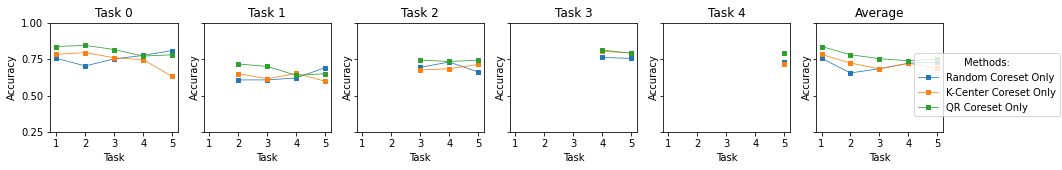

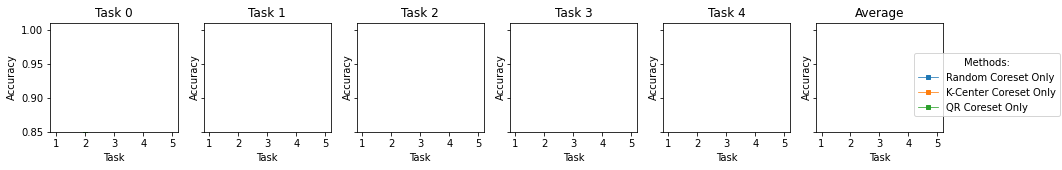

In [25]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

num_tasks = 5
num_epochs = 120 # 100 or 10
single_head = False
batch_size = 256

class_distribution = [
    [0, 1],
    [2, 3],
    [4, 5],
    [6, 7],
    [8, 9]
]

dataset_name="splitCifar"
get_dataloader = lambda: SplitCifar10DataloaderTEST(class_distribution, batch_size, grayscale=False, data_subset=1.0)

model = EDITED_CONV_CURRENT(32*32); 
model.to(device)

data = []; methods = []

# # # Vanilla VCL - no coreset
# dataloaders = get_dataloader()
# all_accs = run_vanilla_vcl(model, dataloaders, num_tasks, num_epochs, device)
# data.append(all_accs); methods.append("VCL")

# Random Coreset Only
coreset_size = 200
coreset_method = coresets.attach_random_coreset_split

model.reset_parameters(); dataloaders = get_dataloader()
all_accs = vcl.run_coresetonly(num_tasks, single_head, num_epochs, dataloaders,
            model, coreset_method, coreset_size, beta=0.01)
data.append(all_accs); methods.append("Random Coreset Only")

# K-center Coreset Only
coreset_size = 200
coreset_method = coresets.attach_kCenter_coreset_split

model.reset_parameters(); dataloaders = get_dataloader()
all_accs = vcl.run_coresetonly(num_tasks, single_head, num_epochs, dataloaders,
            model, coreset_method, coreset_size, beta=0.01)

data.append(all_accs); methods.append("K-Center Coreset Only")

# QR Coreset Only
coreset_size = 200
coreset_method = coresets.attach_qr_coreset_split

model.reset_parameters(); dataloaders = get_dataloader()
all_accs = vcl.run_coresetonly(num_tasks, single_head, num_epochs, dataloaders,
            model, coreset_method, coreset_size, beta=0.01)

data.append(all_accs); methods.append("QR Coreset Only")


plots.split_plot(data, methods)
#np.save("./files/accuracy/1_accs_{fn}".format(fn=dataset_name), data)
#np.save("./files/accuracy/1_meths_{fn}".format(fn=dataset_name), methods)

In [32]:
data


[array([[0.75713642,        nan,        nan,        nan,        nan],
        [0.7042518 , 0.60783504,        nan,        nan,        nan],
        [0.75319261, 0.60794772, 0.6947491 ,        nan,        nan],
        [0.77666767, 0.62158203, 0.73125751, 0.76262019,        nan],
        [0.81058444, 0.69294621, 0.66203425, 0.75646034, 0.73257212]]),
 array([[0.78361629,        nan,        nan,        nan,        nan],
        [0.79634916, 0.65200571,        nan,        nan,        nan],
        [0.76066707, 0.61542218, 0.67649489,        nan,        nan],
        [0.74770883, 0.65253155, 0.68505859, 0.8044997 ,        nan],
        [0.63157302, 0.59885817, 0.71439303, 0.79477163, 0.71435547]]),
 array([[0.83841647,        nan,        nan,        nan,        nan],
        [0.84630409, 0.71766076,        nan,        nan,        nan],
        [0.81734525, 0.70094651, 0.74455379,        nan,        nan],
        [0.77208534, 0.63964844, 0.73505108, 0.8140024 ,        nan],
        [0.78151

#### QR coreset here

In [28]:
## New QR (change to 5: and choosing first column)
def attach_qr_coreset_split_HERE(coresets, sub_train_loader, num_samples=200):

    dataset = sub_train_loader.dataset
    task_indices = sub_train_loader.sampler.indices
    A = torch.stack([dataset[i][0].flatten().float() for i in task_indices])

    P_indices = qrcp(A)

    coreset_indices = task_indices[P_indices[:num_samples]]

    sub_train_loader.sampler.indices = task_indices[P_indices[num_samples:]]
    
    # Create a new DataLoader for the coreset
    coreset_loader = torch.utils.data.DataLoader(
        sub_train_loader.dataset, 
        batch_size=sub_train_loader.batch_size, 
        sampler=torch.utils.data.SubsetRandomSampler(coreset_indices))
    
    # Append the new coreset DataLoader to the list of existing coresets
    coresets.append(coreset_loader)

def qrcp(B):
    A = B.t() #the transpose
    m, n = A.shape
    Q = torch.eye(m, m, dtype=A.dtype, device=A.device)
    R = A.clone()
    P = torch.arange(n, dtype=torch.long, device=A.device)
    for i in range(min(m, n)):
        # Find the pivot - the column with the largest norm
        if i == 0:
            norms = torch.tensor(0)
        else:
            norms = torch.norm(R[i:, i:], dim=0)
        max_norm_col = torch.argmax(norms) + i
        # Swap columns in R and rows in P
        R[:, [i, max_norm_col]] = R[:, [max_norm_col, i]]
        P[i], P[max_norm_col] = P[max_norm_col].item(), P[i].item()
        # Compute the Householder transformation for the current column
        x = R[i:, i]
        rho = -torch.sign(x[0]) if x[0] != 0 else -1
        s = torch.sqrt(0.5 * (1 + abs(rho) * x[0] / torch.norm(x)))
        v = torch.zeros_like(x)
        v[0] = s
        u = (x - rho * v) / (s * x[0])
        v = u - v
        # Apply the transformation to R and Q
        R[i:, i:] -= 2 * v.outer(v @ R[i:, i:])
        Q[:, i:] -= 2 * (Q[:, i:] @ v).outer(v)
    return P

In [36]:
# K-Center + VCL
num_epochs = 20
coreset_size = 200
coreset_method = coresets.attach_kCenter_coreset_split

model.reset_parameters(); dataloaders = get_dataloader()
all_accs = vcl.run_vcl(num_tasks, single_head, num_epochs, dataloaders,
            model, coreset_method, coreset_size, beta=0.01)

print(all_accs)

Files already downloaded and verified
Files already downloaded and verified


c:\Users\Dell 5520\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Starting Task 1






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [01:10<04:41, 70.32s/it]



 40%|████      | 2/5 [02:27<03:37, 72.46s/it]



 60%|██████    | 3/5 [03:38<02:23, 71.86s/it]



 80%|████████  | 4/5 [04:47<01:11, 71.20s/it]



100%|██████████| 5/5 [06:00<00:00, 71.71s/it]

Done Training Task 1
Replaying Task 1






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  2.54it/s]



 40%|████      | 2/5 [00:00<00:01,  2.63it/s]



 60%|██████    | 3/5 [00:01<00:00,  2.71it/s]



 80%|████████  | 4/5 [00:01<00:00,  2.75it/s]



100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Task 1 Accuracy: 0.8605769230769231

Starting Task 2






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [01:38<06:35, 98.98s/it]



 40%|████      | 2/5 [02:56<04:37, 92.43s/it]



 60%|██████    | 3/5 [04:19<02:59, 89.58s/it]



 80%|████████  | 4/5 [05:38<01:26, 86.64s/it]



100%|██████████| 5/5 [06:57<00:00, 84.10s/it]

Done Training Task 2
Replaying Task 1






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  2.54it/s]



 40%|████      | 2/5 [00:00<00:01,  2.58it/s]



 60%|██████    | 3/5 [00:01<00:00,  2.63it/s]



 80%|████████  | 4/5 [00:01<00:00,  2.68it/s]



100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

Replaying Task 2






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.26it/s]



 40%|████      | 2/5 [00:00<00:00,  3.19it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.13it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.11it/s]



100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


Task 1 Accuracy: 0.8599008413461539
Task 2 Accuracy: 0.7447791466346154

Starting Task 3






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [01:22<05:29, 82.40s/it]



 40%|████      | 2/5 [02:42<04:05, 81.73s/it]



 60%|██████    | 3/5 [03:59<02:40, 80.31s/it]



 80%|████████  | 4/5 [05:15<01:18, 78.89s/it]



100%|██████████| 5/5 [06:34<00:00, 78.93s/it]

Done Training Task 3
Replaying Task 1






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  2.84it/s]



 40%|████      | 2/5 [00:00<00:01,  2.89it/s]



 60%|██████    | 3/5 [00:01<00:00,  2.87it/s]



 80%|████████  | 4/5 [00:01<00:00,  2.85it/s]



100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

Replaying Task 2






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  2.72it/s]



 40%|████      | 2/5 [00:00<00:01,  2.84it/s]



 60%|██████    | 3/5 [00:01<00:00,  2.93it/s]



 80%|████████  | 4/5 [00:01<00:00,  2.78it/s]



100%|██████████| 5/5 [00:01<00:00,  2.40it/s]

Replaying Task 3






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  2.03it/s]



 40%|████      | 2/5 [00:00<00:01,  2.16it/s]



 60%|██████    | 3/5 [00:01<00:00,  2.16it/s]



 80%|████████  | 4/5 [00:01<00:00,  2.08it/s]



100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Task 1 Accuracy: 0.8500600961538461
Task 2 Accuracy: 0.7410606971153846
Task 3 Accuracy: 0.7916917067307692

Starting Task 4






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [01:22<05:28, 82.21s/it]



 40%|████      | 2/5 [02:40<04:03, 81.18s/it]



 60%|██████    | 3/5 [04:04<02:43, 81.84s/it]



 80%|████████  | 4/5 [05:30<01:23, 83.02s/it]



100%|██████████| 5/5 [06:46<00:00, 80.91s/it]

Done Training Task 4
Replaying Task 1






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  2.61it/s]



 40%|████      | 2/5 [00:00<00:01,  2.58it/s]



 60%|██████    | 3/5 [00:01<00:00,  2.61it/s]



 80%|████████  | 4/5 [00:01<00:00,  2.62it/s]



100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

Replaying Task 2






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  2.63it/s]



 40%|████      | 2/5 [00:00<00:01,  2.43it/s]



 60%|██████    | 3/5 [00:01<00:00,  2.27it/s]



 80%|████████  | 4/5 [00:02<00:00,  1.94it/s]



100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

Replaying Task 3






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:02,  1.88it/s]



 40%|████      | 2/5 [00:01<00:01,  1.82it/s]



 60%|██████    | 3/5 [00:01<00:01,  1.86it/s]



 80%|████████  | 4/5 [00:02<00:00,  1.94it/s]



100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

Replaying Task 4






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:02,  1.93it/s]



 40%|████      | 2/5 [00:01<00:01,  1.92it/s]



 60%|██████    | 3/5 [00:01<00:00,  2.03it/s]



 80%|████████  | 4/5 [00:01<00:00,  2.06it/s]



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Task 1 Accuracy: 0.8361628605769231
Task 2 Accuracy: 0.7329852764423077
Task 3 Accuracy: 0.7824519230769231
Task 4 Accuracy: 0.8879582331730769

Starting Task 5






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [01:40<06:42, 100.72s/it]



 40%|████      | 2/5 [03:39<05:18, 106.09s/it]



 60%|██████    | 3/5 [05:28<03:34, 107.09s/it]



 80%|████████  | 4/5 [07:09<01:45, 105.25s/it]



100%|██████████| 5/5 [08:52<00:00, 104.37s/it]

Done Training Task 5
Replaying Task 1






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  2.51it/s]



 40%|████      | 2/5 [00:00<00:01,  2.56it/s]



 60%|██████    | 3/5 [00:01<00:00,  2.55it/s]



 80%|████████  | 4/5 [00:01<00:00,  1.97it/s]



100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

Replaying Task 2






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:03,  1.29it/s]



 40%|████      | 2/5 [00:01<00:02,  1.30it/s]



 60%|██████    | 3/5 [00:02<00:01,  1.30it/s]



 80%|████████  | 4/5 [00:03<00:00,  1.33it/s]



100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

Replaying Task 3






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:02,  1.39it/s]



 40%|████      | 2/5 [00:01<00:02,  1.47it/s]



 60%|██████    | 3/5 [00:01<00:01,  1.51it/s]



 80%|████████  | 4/5 [00:02<00:00,  1.55it/s]



100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

Replaying Task 4






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:02,  1.38it/s]



 40%|████      | 2/5 [00:01<00:01,  1.51it/s]



 60%|██████    | 3/5 [00:01<00:01,  1.46it/s]



 80%|████████  | 4/5 [00:02<00:00,  1.55it/s]



100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

Replaying Task 5






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  2.04it/s]



 40%|████      | 2/5 [00:00<00:01,  2.04it/s]



 60%|██████    | 3/5 [00:01<00:01,  2.00it/s]



 80%|████████  | 4/5 [00:02<00:00,  1.99it/s]



100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Task 1 Accuracy: 0.7987530048076923
Task 2 Accuracy: 0.7242337740384616
Task 3 Accuracy: 0.7809119591346154
Task 4 Accuracy: 0.8834885817307692
Task 5 Accuracy: 0.8244065504807692

[[0.86057692        nan        nan        nan        nan]
 [0.85990084 0.74477915        nan        nan        nan]
 [0.8500601  0.7410607  0.79169171        nan        nan]
 [0.83616286 0.73298528 0.78245192 0.88795823        nan]
 [0.798753   0.72423377 0.78091196 0.88348858 0.82440655]]
[[0.86057692        nan        nan        nan        nan]
 [0.85990084 0.74477915        nan        nan        nan]
 [0.8500601  0.7410607  0.79169171        nan        nan]
 [0.83616286 0.73298528 0.78245192 0.88795823        nan]
 [0.798753   0.72423377 0.78091196 0.88348858 0.82440655]]


In [35]:
# QR Coreset + VCL
num_epochs = 5
coreset_size = 40
coreset_method = attach_qr_coreset_split_HERE

model.reset_parameters(); dataloaders = get_dataloader()
all_accs = vcl.run_vcl(num_tasks, single_head, num_epochs, dataloaders,
            model, coreset_method, coreset_size, beta=0.01)

print(all_accs)

Files already downloaded and verified
Files already downloaded and verified


c:\Users\Dell 5520\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Starting Task 1






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [01:06<04:26, 66.55s/it]



 40%|████      | 2/5 [02:12<03:19, 66.47s/it]



 60%|██████    | 3/5 [03:19<02:13, 66.55s/it]



 80%|████████  | 4/5 [04:26<01:06, 66.66s/it]



100%|██████████| 5/5 [05:32<00:00, 66.41s/it]

Done Training Task 1
Replaying Task 1






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.33it/s]



 40%|████      | 2/5 [00:00<00:00,  3.36it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.34it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.39it/s]



100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Task 1 Accuracy: 0.8717322716346154

Starting Task 2






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [01:06<04:27, 66.83s/it]



 40%|████      | 2/5 [02:12<03:19, 66.52s/it]



 60%|██████    | 3/5 [03:18<02:12, 66.20s/it]



 80%|████████  | 4/5 [04:23<01:06, 66.03s/it]



100%|██████████| 5/5 [05:32<00:00, 66.98s/it]

Done Training Task 2
Replaying Task 1






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.09it/s]



 40%|████      | 2/5 [00:00<00:00,  3.13it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.22it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.30it/s]



100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

Replaying Task 2






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.39it/s]



 40%|████      | 2/5 [00:00<00:00,  3.35it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.38it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.37it/s]



100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


Task 1 Accuracy: 0.8673001802884616
Task 2 Accuracy: 0.73583984375

Starting Task 3






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [01:06<04:26, 66.59s/it]



 40%|████      | 2/5 [02:12<03:19, 66.39s/it]



 60%|██████    | 3/5 [03:18<02:12, 66.30s/it]



 80%|████████  | 4/5 [04:24<01:06, 66.13s/it]



100%|██████████| 5/5 [05:30<00:00, 66.25s/it]

Done Training Task 3
Replaying Task 1






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.32it/s]



 40%|████      | 2/5 [00:00<00:00,  3.32it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.36it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.29it/s]



100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

Replaying Task 2






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.07it/s]



 40%|████      | 2/5 [00:00<00:00,  3.14it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.18it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.21it/s]



100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

Replaying Task 3






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.36it/s]



 40%|████      | 2/5 [00:00<00:00,  3.26it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.33it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.36it/s]



100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Task 1 Accuracy: 0.8592998798076923
Task 2 Accuracy: 0.7251727764423077
Task 3 Accuracy: 0.7832406850961539

Starting Task 4






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [01:07<04:31, 67.99s/it]



 40%|████      | 2/5 [02:14<03:22, 67.46s/it]



 60%|██████    | 3/5 [03:20<02:14, 67.12s/it]



 80%|████████  | 4/5 [04:26<01:06, 66.70s/it]



100%|██████████| 5/5 [05:32<00:00, 66.63s/it]

Done Training Task 4
Replaying Task 1






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.23it/s]



 40%|████      | 2/5 [00:00<00:00,  3.25it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.28it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.26it/s]



100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

Replaying Task 2






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.42it/s]



 40%|████      | 2/5 [00:00<00:00,  3.40it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.42it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.37it/s]



100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

Replaying Task 3






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.13it/s]



 40%|████      | 2/5 [00:00<00:00,  3.20it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.26it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.30it/s]



100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

Replaying Task 4






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.13it/s]



 40%|████      | 2/5 [00:00<00:00,  3.19it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.27it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.28it/s]



100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


Task 1 Accuracy: 0.8605393629807692
Task 2 Accuracy: 0.7114633413461539
Task 3 Accuracy: 0.7823016826923077
Task 4 Accuracy: 0.8811974158653846

Starting Task 5






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [01:05<04:22, 65.71s/it]



 40%|████      | 2/5 [02:11<03:17, 65.78s/it]



 60%|██████    | 3/5 [03:18<02:12, 66.04s/it]



 80%|████████  | 4/5 [04:24<01:06, 66.00s/it]



100%|██████████| 5/5 [05:32<00:00, 66.59s/it]

Done Training Task 5
Replaying Task 1






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.18it/s]



 40%|████      | 2/5 [00:00<00:00,  3.22it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.23it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.30it/s]



100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

Replaying Task 2






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.32it/s]



 40%|████      | 2/5 [00:00<00:00,  3.35it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.36it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.34it/s]



100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

Replaying Task 3






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.27it/s]



 40%|████      | 2/5 [00:00<00:00,  3.32it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.34it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.37it/s]



100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

Replaying Task 4






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.41it/s]



 40%|████      | 2/5 [00:00<00:00,  3.37it/s]



 60%|██████    | 3/5 [00:00<00:00,  3.41it/s]



 80%|████████  | 4/5 [00:01<00:00,  3.37it/s]



100%|██████████| 5/5 [00:01<00:00,  3.38it/s]

Replaying Task 5






  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  2.44it/s]



 40%|████      | 2/5 [00:00<00:01,  2.69it/s]



 60%|██████    | 3/5 [00:01<00:00,  2.83it/s]



 80%|████████  | 4/5 [00:01<00:00,  2.97it/s]



100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Task 1 Accuracy: 0.8447265625
Task 2 Accuracy: 0.7102238581730769
Task 3 Accuracy: 0.7756911057692308
Task 4 Accuracy: 0.8736478365384616
Task 5 Accuracy: 0.8166691706730769

[[0.87173227        nan        nan        nan        nan]
 [0.86730018 0.73583984        nan        nan        nan]
 [0.85929988 0.72517278 0.78324069        nan        nan]
 [0.86053936 0.71146334 0.78230168 0.88119742        nan]
 [0.84472656 0.71022386 0.77569111 0.87364784 0.81666917]]
[[0.87173227        nan        nan        nan        nan]
 [0.86730018 0.73583984        nan        nan        nan]
 [0.85929988 0.72517278 0.78324069        nan        nan]
 [0.86053936 0.71146334 0.78230168 0.88119742        nan]
 [0.84472656 0.71022386 0.77569111 0.87364784 0.81666917]]


### end of coreset qr here